In [ ]:
from memflow.read_data.dataset_all import DatasetCombined
from memflow.unfolding_network.conditional_transformer import ConditioningTransformerLayer
from memflow.unfolding_flow.utils import *

import numpy as np
import scipy.stats as st
import torch
from torch import optim
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.functional import normalize
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
from matplotlib import cm

from tensorboardX import SummaryWriter
from omegaconf import OmegaConf
import sys
import argparse
import os
from pynvml import *
from hist import Hist
import hist
import vector
import mplhep
import awkward as ak

from memflow.read_data.utils import to_flat_tensor
from memflow.phasespace.phasespace import PhaseSpace

from utils import FindMasks
from utils import SavePlots
from utils import plot_regressionFactor

pi = torch.pi

In [ ]:
def plot_var2d(higgs_var1, higgs_var2, thad_var1, thad_var2, tlep_var1, tlep_var2,
             ISR_var1, ISR_var2, name1, name2, nameFig, start1=0, stop1=1000, start2=0, stop2=1000, bins1=100, bins2=100,
             higgs_mask=1, thad_mask=1, tlep_mask=1, ISR_mask=1, neg_Mask=False, log=False, name='da', nameunit=''):
        
        
        if neg_Mask:
            higgs_mask = np.logical_not(higgs_mask)
            thad_mask = np.logical_not(thad_mask)
            tlep_mask = np.logical_not(tlep_mask)
            ISR_mask = np.logical_not(ISR_mask)

        # Quick construction, no other imports needed:
        hist2d_var_higgs = (
          Hist.new
          .Reg(bins=bins1, start=start1, stop=stop1, name=name1, label=name1)
          .Reg(bins=bins2, start=start2, stop=stop2, name=name2, label=name2)
          .Double())

        hist2d_var_thad = (
          Hist.new
          .Reg(bins=bins1, start=start1, stop=stop1, name=name1, label=name1)
          .Reg(bins=bins2, start=start2, stop=stop2, name=name2, label=name2)
          .Double())

        hist2d_var_tlep = (
          Hist.new
          .Reg(bins=bins1, start=start1, stop=stop1, name=name1, label=name1)
          .Reg(bins=bins2, start=start2, stop=stop2, name=name2, label=name2)
          .Double())

        hist2d_var_ISR = (
          Hist.new
          .Reg(bins=bins1, start=start1, stop=stop1, name=name1, label=name1)
          .Reg(bins=bins2, start=start2, stop=stop2, name=name2, label=name2)
          .Double())

        hist2d_var_higgs.fill(higgs_var1[higgs_mask],
                            higgs_var2[higgs_mask])

        hist2d_var_thad.fill(thad_var1[thad_mask],
                            thad_var2[thad_mask])

        hist2d_var_tlep.fill(tlep_var1[tlep_mask],
                            tlep_var2[tlep_mask])

        hist2d_var_ISR.fill(ISR_var1[ISR_mask],
                            ISR_var2[ISR_mask])

        colormap='viridis'
        my_viridis = mpl.colormaps[colormap].with_extremes(under="white")
        
        fontsize = 20
        labelsize=14
        labels = ['higgs', 'thad', 'tlep', 'ISR']
        hist2d_list = [hist2d_var_higgs, hist2d_var_thad, hist2d_var_tlep, hist2d_var_ISR]
        
        
        fig, axs = plt.subplots(1, 4, figsize=(16, 6))

        if log:
            for i in range(4):
                w, x, y = hist2d_list[i].to_numpy()
                mesh = axs[i].pcolormesh(x, y, w.T, cmap=my_viridis, norm=mpl.colors.LogNorm(vmin=1))
                axs[i].set_xlabel(f"{name}-correct {nameunit}", fontsize=fontsize)
                axs[i].set_ylabel(f"{name}-regressed {nameunit}", fontsize=fontsize)
                axs[i].set_title(f"{labels[i]}", fontsize=fontsize)
                axs[i].tick_params(axis='both', which='major', labelsize=labelsize)
                cbar = fig.colorbar(mesh)
                cbar.ax.tick_params(labelsize=labelsize)
                plt.tight_layout()

        else:
            for i in range(4):
                w, x, y = hist2d_list[i].to_numpy()
                mesh = axs[i].pcolormesh(x, y, w.T, cmap=my_viridis, vmin=1)
                axs[i].set_xlabel(f"{name}-correct {nameunit}", fontsize=fontsize)
                axs[i].set_ylabel(f"{name}-regressed {nameunit}", fontsize=fontsize)
                axs[i].set_title(f"{labels[i]}", fontsize=fontsize)
                axs[i].tick_params(axis='both', which='major', labelsize=labelsize)
                cbar = fig.colorbar(mesh)
                cbar.ax.tick_params(labelsize=labelsize)
                plt.tight_layout()

In [3]:
device = torch.device('cpu')

data = DatasetCombined('/work/adpetre/dataset_new/all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov.parquet', dev=device, dtype=torch.float64, build=True,
                        reco_list=['data_boost'],
                        parton_list=['data_higgs_t_tbar_ISR',
                                    'phasespace_intermediateParticles',
                                     'phasespace_intermediateParticles_onShell',
                                    'phasespace_rambo_detjacobian'])


RecoLevel


KeyboardInterrupt: 

In [4]:
#path_data = '../../dataset/v7/all_jets_fullRun2_v1.parquet'
path_data = '/work/adpetre/dataset_new/all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov.parquet'
device = torch.device('cpu')

data = DatasetCombined(path_data, dev=device,
                        reco_list=['data_boost'],
                        parton_list=['H_thad_tlep_ISR_cartesian',
                                    'phasespace_intermediateParticles',
                                    'phasespace_intermediateParticles_onShell',
                                    'phasespace_rambo_detjacobian'])

data_onShell = data.parton_data.data_higgs_t_tbar_ISR_cartesian_onShell
PS_onShell = data.parton_data.phasespace_intermediateParticles_onShell

higgsCorrect = vector.array(
    {
        "E": data_onShell[:,0,0].detach().numpy(),
        "px": data_onShell[:,0,1].detach().numpy(),
        "py": data_onShell[:,0,2].detach().numpy(),
        "pz": data_onShell[:,0,3].detach().numpy(),
    }
)

thadCorrect = vector.array(
    {
        "E": data_onShell[:,1,0].detach().numpy(),
        "px": data_onShell[:,1,1].detach().numpy(),
        "py": data_onShell[:,1,2].detach().numpy(),
        "pz": data_onShell[:,1,3].detach().numpy(),
    }
)

tlepCorrect = vector.array(
    {
        "E": data_onShell[:,2,0].detach().numpy(),
        "px": data_onShell[:,2,1].detach().numpy(),
        "py": data_onShell[:,2,2].detach().numpy(),
        "pz": data_onShell[:,2,3].detach().numpy(),
    }
)

glISRCorrect = vector.array(
    {
        "E": data_onShell[:,3,0].detach().numpy(),
        "px": data_onShell[:,3,1].detach().numpy(),
        "py": data_onShell[:,3,2].detach().numpy(),
        "pz": data_onShell[:,3,3].detach().numpy(),
    }
)

higgsCorrect = ak.with_name(higgsCorrect, name="Momentum4D")
thadCorrect = ak.with_name(thadCorrect, name="Momentum4D")
tlepCorrect = ak.with_name(tlepCorrect, name="Momentum4D")
glISRCorrect = ak.with_name(glISRCorrect, name="Momentum4D")


RecoLevel
Reading reco_level Files

PartonLevel
Reading parton_level Files
Load phasespace_intermediateParticles
Load phasespace_intermediateParticles_onShell
Load phasespace_rambo_detjacobian



In [5]:
for p in range(4):
    mass = torch.sqrt(data_onShell[:,p,0]**2 - data_onShell[:,p,1]**2 - data_onShell[:,p,2]**2 - data_onShell[:,p,3]**2)
    print(mass)
    print(torch.count_nonzero(torch.isnan(mass)))

tensor([125.2500, 125.2500, 125.2500,  ..., 125.2500, 125.2500, 125.2500])
tensor(0)
tensor([172.5000, 172.5000, 172.5000,  ..., 172.5000, 172.5000, 172.5000])
tensor(0)
tensor([172.5000, 172.5000, 172.5000,  ..., 172.5000, 172.5000, 172.5000])
tensor(0)
tensor([0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010])
tensor(0)


In [6]:
def checkCM(tensor):
    sum_px = tensor[:,0,1] + tensor[:,1,1] + tensor[:,2,1] + tensor[:,3,1]
    sum_py = tensor[:,0,2] + tensor[:,1,2] + tensor[:,2,2] + tensor[:,3,2]
    sum_pz = tensor[:,0,3] + tensor[:,1,3] + tensor[:,2,3] + tensor[:,3,3]
    print(f'{sum_px}\n {sum_py}\n {sum_pz}')
    
def checkCM2(tensor):
    sum = torch.sum(tensor, dim=1)
    print(sum[:,1:])

In [7]:
checkCM(data_onShell)

checkCM2(data_onShell)

tensor([-1.4211e-14,  2.1538e-14,  2.8422e-14,  ...,  4.2633e-14,
        -7.1054e-14,  7.1054e-14])
 tensor([-1.2434e-14,  1.6875e-14, -1.3323e-14,  ...,  2.8422e-14,
         5.3291e-15,  3.5527e-14])
 tensor([ 0.0000e+00,  1.1369e-13,  1.1369e-13,  ...,  1.1369e-13,
         0.0000e+00, -1.0658e-14])
tensor([[-1.4211e-14, -1.2434e-14,  0.0000e+00],
        [ 2.1538e-14,  1.6875e-14,  1.1369e-13],
        [ 2.8422e-14, -1.3323e-14,  1.1369e-13],
        ...,
        [ 4.2633e-14,  2.8422e-14,  1.1369e-13],
        [-7.1054e-14,  5.3291e-15,  0.0000e+00],
        [ 7.1054e-14,  3.5527e-14, -1.0658e-14]])


Phasespace class: masses: tensor([1.2525e+02, 1.7250e+02, 1.7250e+02, 1.0000e-03])
tensor(0.)


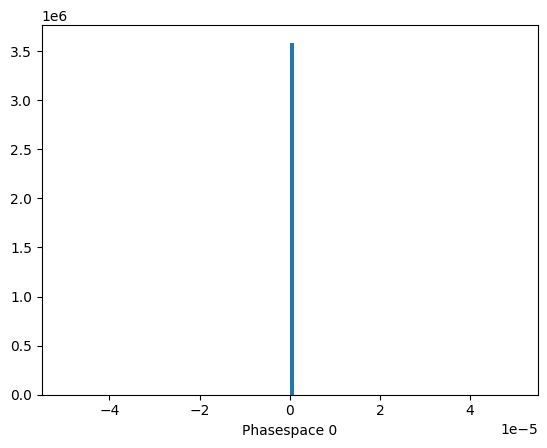

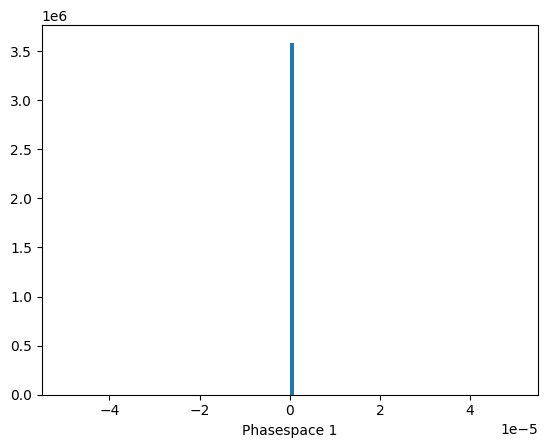

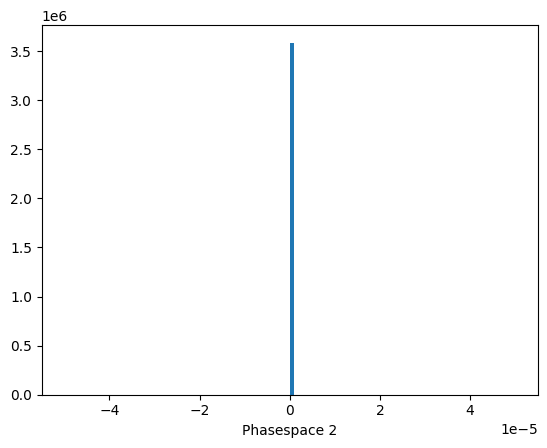

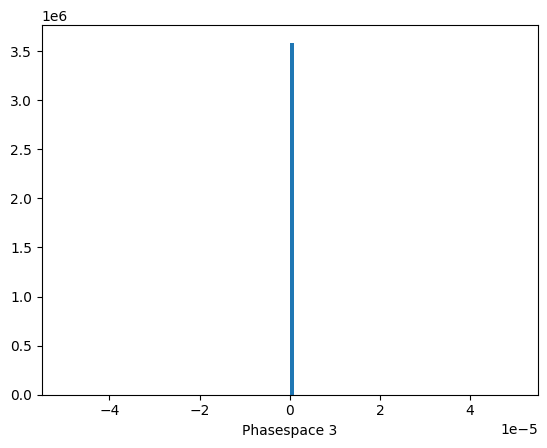

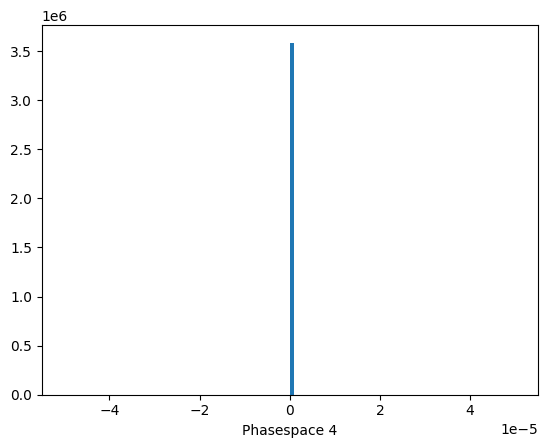

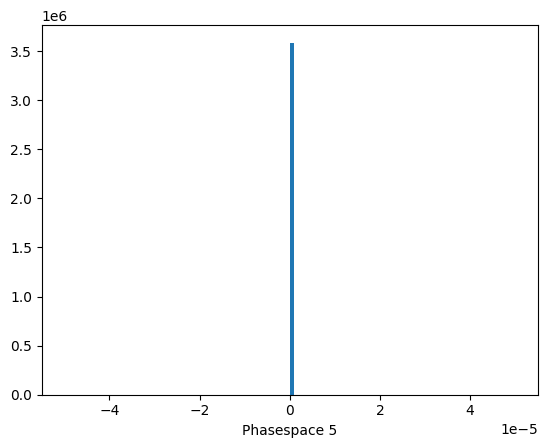

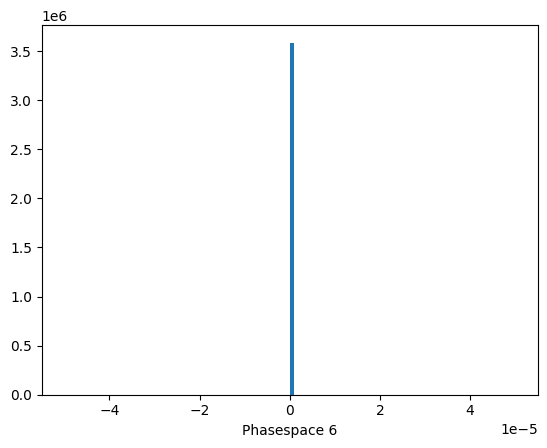

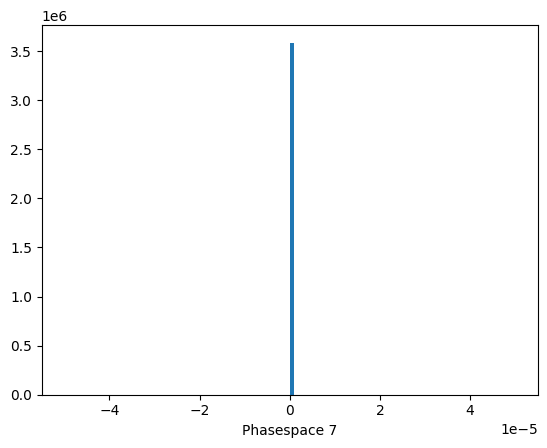

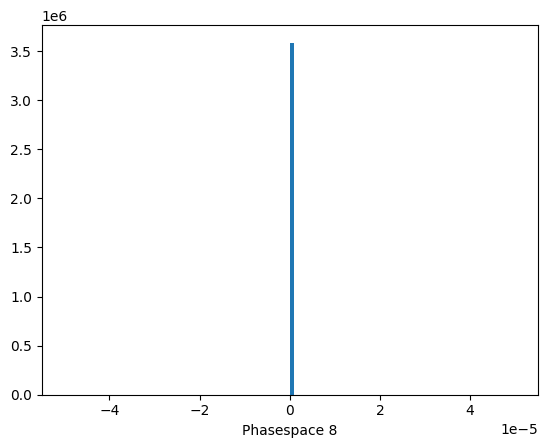

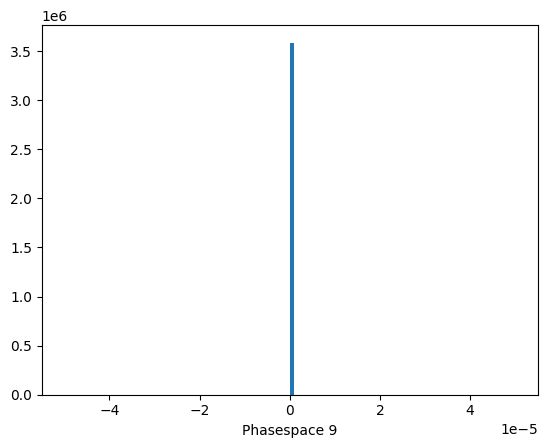

In [8]:
E_CM = 13000
phasespace = PhaseSpace(E_CM, [21, 21], [25, 6, -6, 21], final_masses=torch.Tensor([125.25, 172.5, 172.5, 0.001]), dev="cpu")

incoming_p_boost = data.parton_data.data_boost
x1 = (incoming_p_boost[:, 0, 0] + incoming_p_boost[:, 0, 3]) / E_CM
x2 = (incoming_p_boost[:, 0, 0] - incoming_p_boost[:, 0, 3]) / E_CM

PS, detjac = phasespace.get_ps_from_momenta(data_onShell, x1, x2)
PS[:,8:] = torch.clamp(PS[:,8:], max=0.9999999)

PS_onShell[:,8:] = torch.clamp(PS_onShell[:,8:], max=0.9999999)


print(torch.max(PS-PS_onShell))

for i in range(10):
    plt.hist((PS-PS_onShell)[:,i].numpy(), bins=100, range=(-5e-5, 5e-5))
    plt.xlabel(f"Phasespace {i}")
    plt.show()

In [28]:
mask = PS >= 1.0
print(torch.count_nonzero(mask))

tensor(0)


tensor(0)
tensor([[ 145.0446,   34.3827,   49.2197,   41.7805],
        [ 212.6592,   46.3534,  -47.3328, -105.2551],
        [ 239.2599, -164.0671,  -12.6261,   20.2891],
        [  94.4689,   83.3310,   10.7391,   43.1856]])
tensor([[ 145.0736,   34.4098,   49.2585,   41.8134],
        [ 212.7186,   46.3971,  -47.3674, -105.3402],
        [ 239.3721, -164.2296,  -12.6418,   20.2877],
        [  94.5756,   83.4226,   10.7507,   43.2391]])


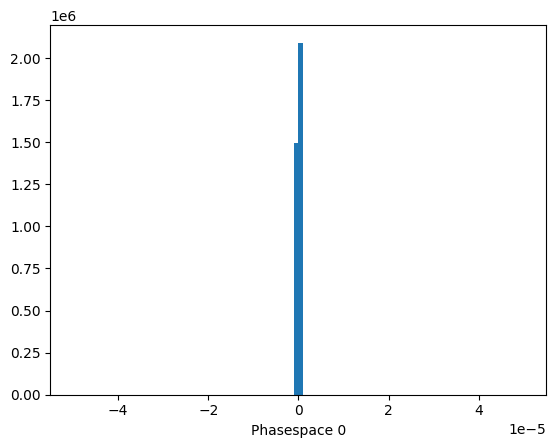

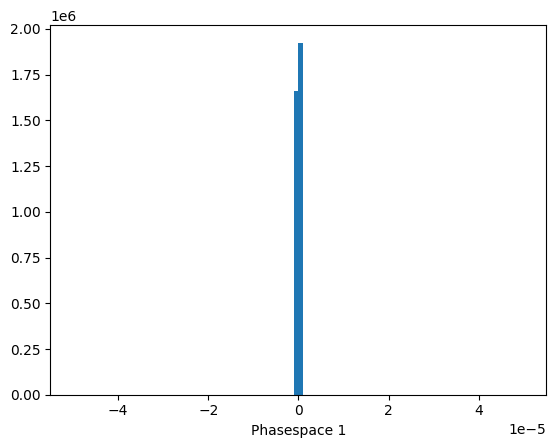

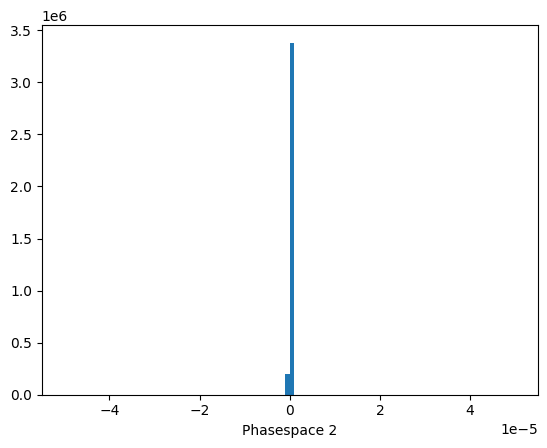

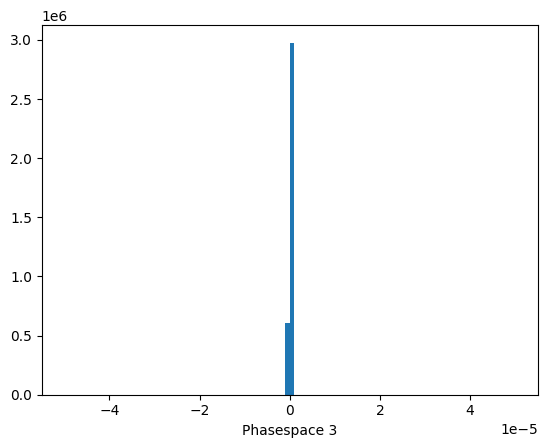

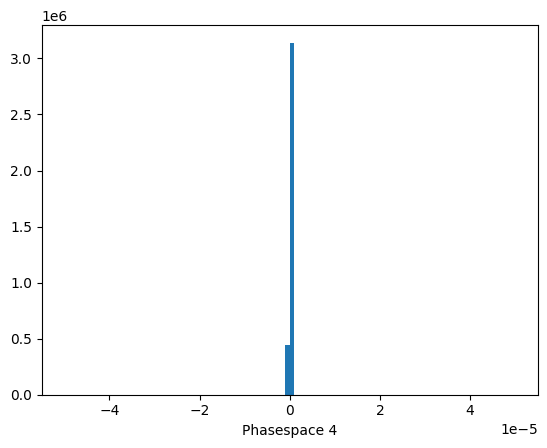

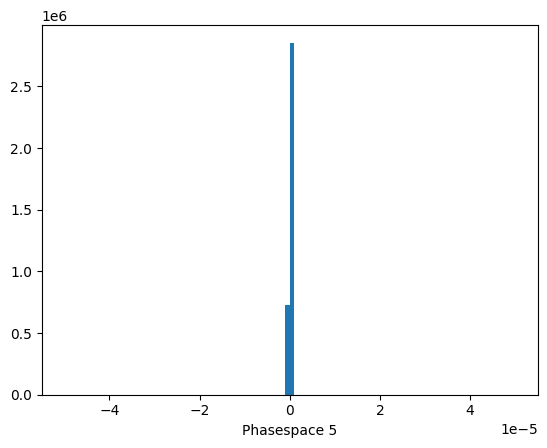

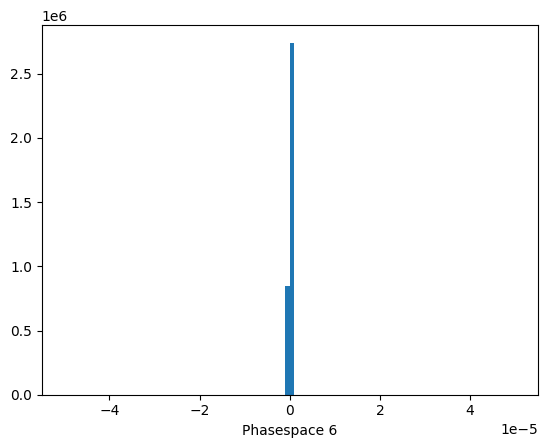

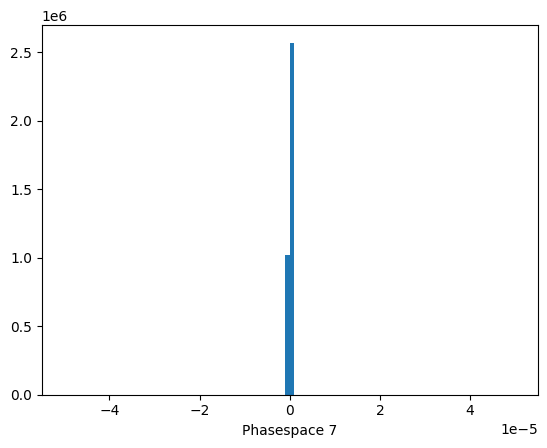

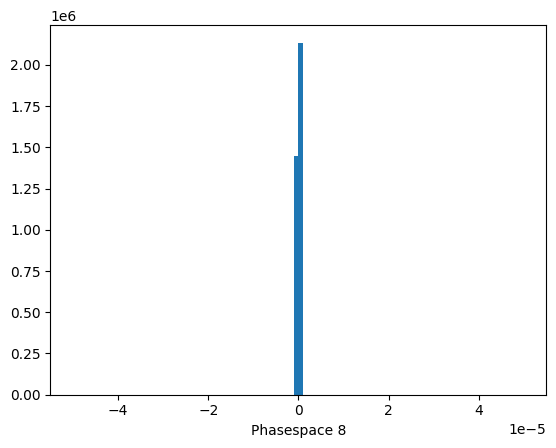

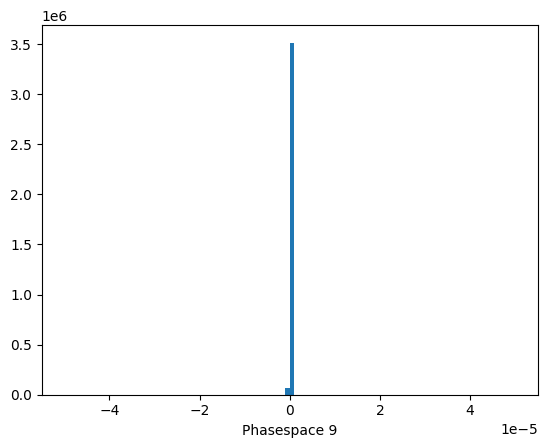

In [29]:
mom, w, x11, x22 = phasespace.get_momenta_from_ps(PS)
print(torch.count_nonzero(torch.isnan(mom)))

print(mom[0,2:])
print(data_onShell[0])


PS2, detjac = phasespace.get_ps_from_momenta(mom[:,2:], x11, x22)
PS2[:,8:] = torch.clamp(PS2[:,8:], max=0.9999999)

for i in range(10):
    plt.hist((PS2-PS_onShell)[:,i].numpy(), bins=100, range=(-5e-5, 5e-5))
    plt.xlabel(f"Phasespace {i}")
    plt.show()

In [30]:
print(torch.count_nonzero(torch.isnan(PS2)))

tensor(0)


In [31]:
mom2, w, x1, x2 = phasespace.get_momenta_from_ps(PS2)

PS3, detjac = phasespace.get_ps_from_momenta(mom2[:,2:], x11, x22)
PS3[:,8:] = torch.clamp(PS3[:,8:], max=0.9999999)

mom3, w, x1, x2 = phasespace.get_momenta_from_ps(PS3)


print(mom3[1,2:])
print(mom2[1,2:])
print(mom[1,2:])
print(data_onShell[1])


tensor([[ 151.8511,   30.0145,   66.1602,  -45.7511],
        [ 226.1006,   34.3030,  -14.6278,  141.3313],
        [ 395.1258,  -65.9186,  -55.9811,  344.8029],
        [ 440.4085,    1.6011,    4.4487, -440.3831]])
tensor([[ 151.8511,   30.0145,   66.1602,  -45.7511],
        [ 226.1006,   34.3030,  -14.6278,  141.3313],
        [ 395.1258,  -65.9186,  -55.9811,  344.8029],
        [ 440.4085,    1.6011,    4.4487, -440.3831]])
tensor([[ 151.8511,   30.0145,   66.1602,  -45.7511],
        [ 226.1006,   34.3030,  -14.6278,  141.3313],
        [ 395.1258,  -65.9186,  -55.9811,  344.8029],
        [ 440.4085,    1.6011,    4.4487, -440.3831]])
tensor([[ 152.1329,   30.1884,   66.5434,  -46.0161],
        [ 226.6652,   34.5475,  -14.6541,  142.1710],
        [ 397.9796,  -66.3975,  -56.4028,  347.9103],
        [ 444.0913,    1.6617,    4.5134, -444.0652]])


In [130]:
p = 3
mass_onShell = torch.sqrt(data_onShell[:,p,0]**2 - data_onShell[:,p,1]**2 - data_onShell[:,p,2]**2 - data_onShell[:,p,3]**2)
mass = torch.sqrt(mom3[:,p+2,0]**2 - mom3[:,p+2,1]**2 - mom3[:,p+2,2]**2 - mom3[:,p+2,3]**2)

print((mass_onShell - mass).max())

tensor(1.8624e-06)


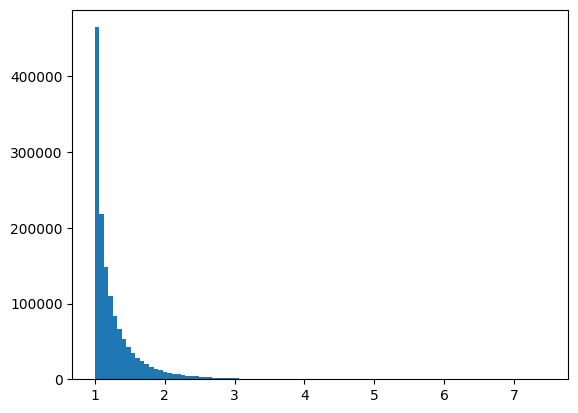

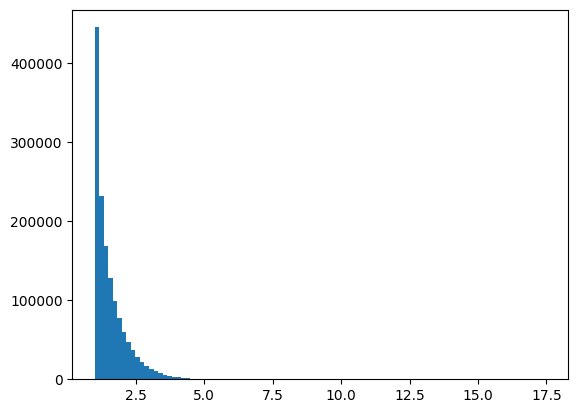

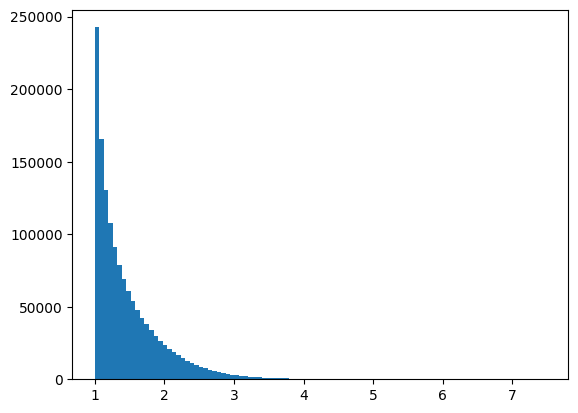

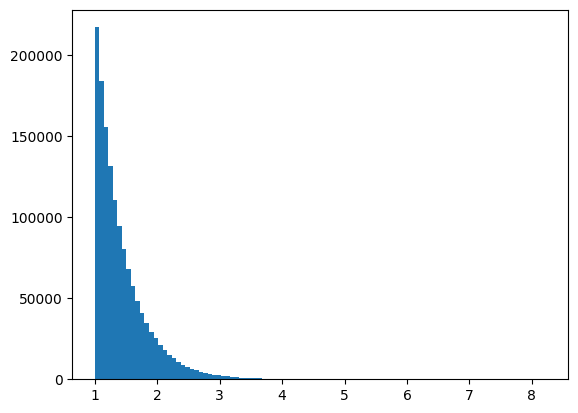

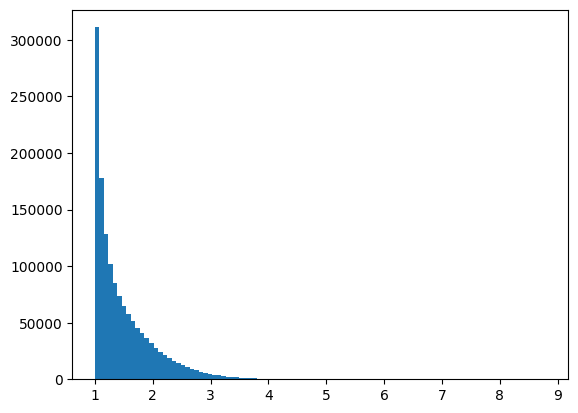

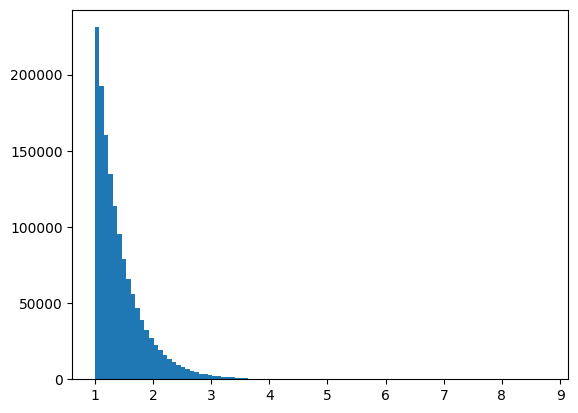

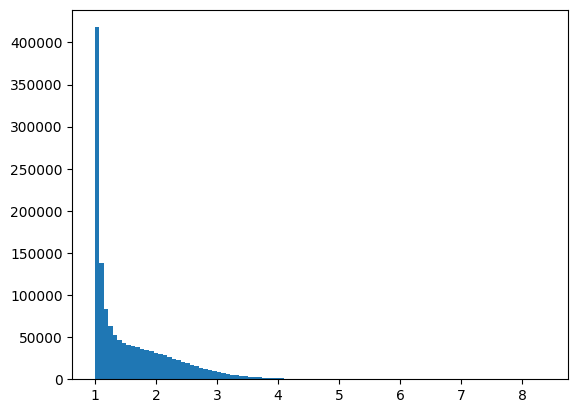

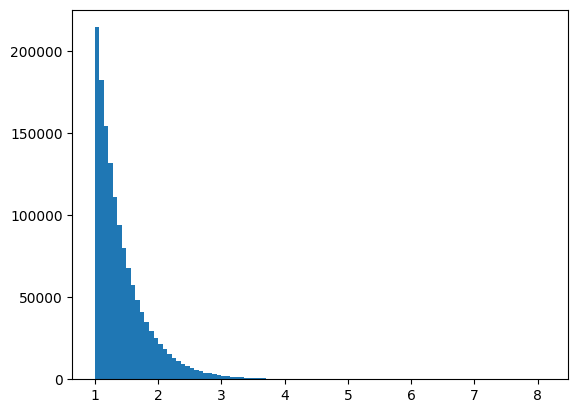

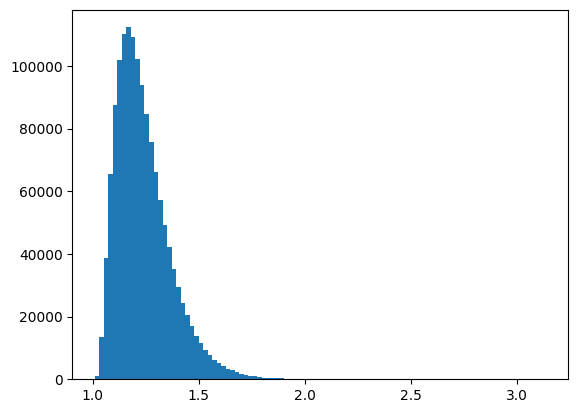

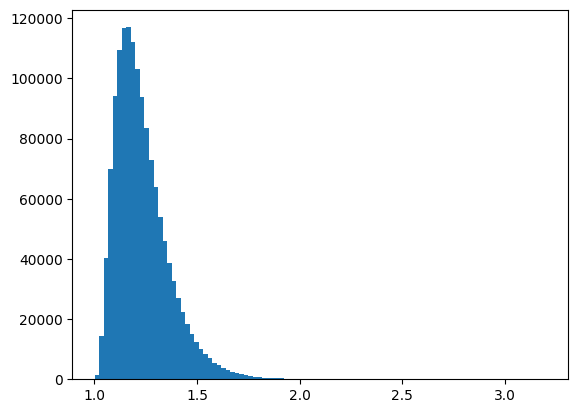

In [37]:
for i in range(10):
    plt.hist(1 - np.log10(PS[:,i].detach()).numpy(), bins=100)
    plt.show()

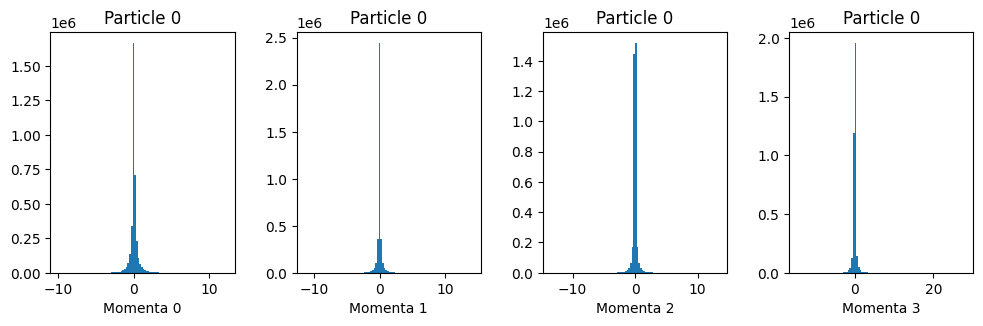

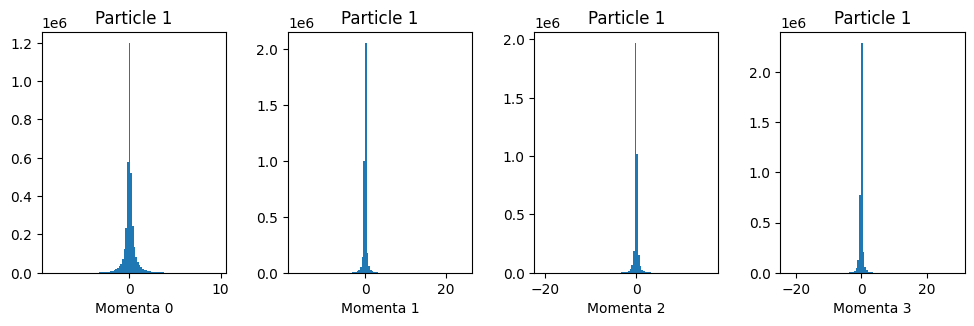

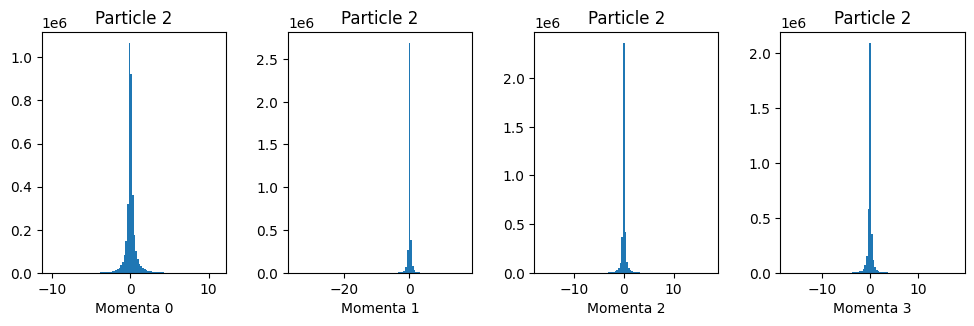

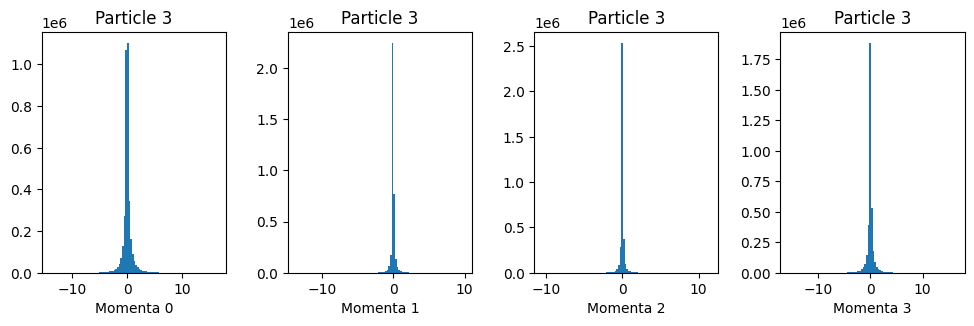

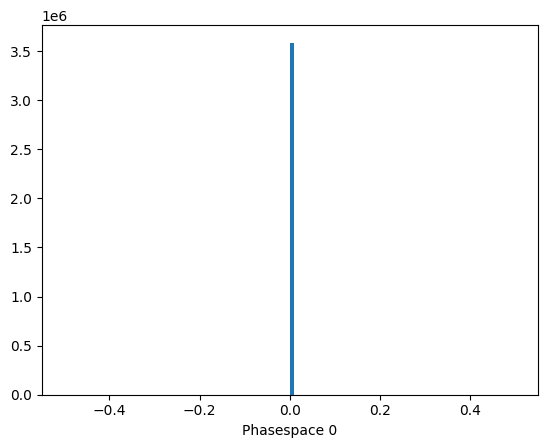

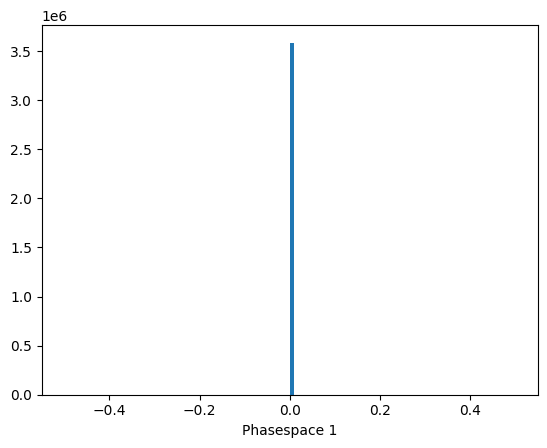

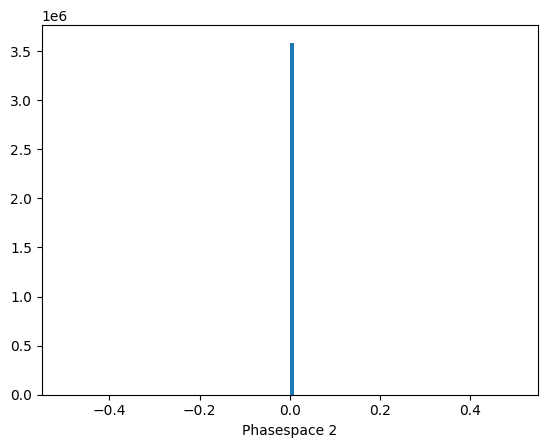

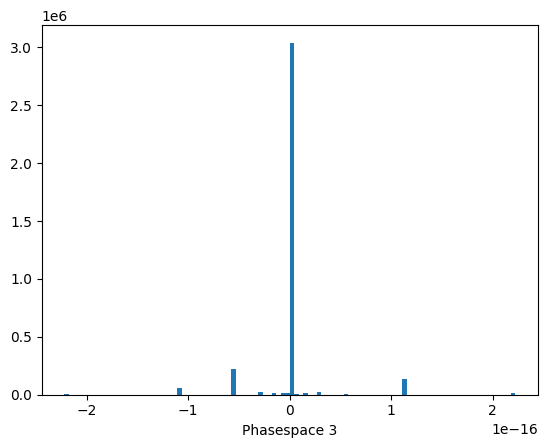

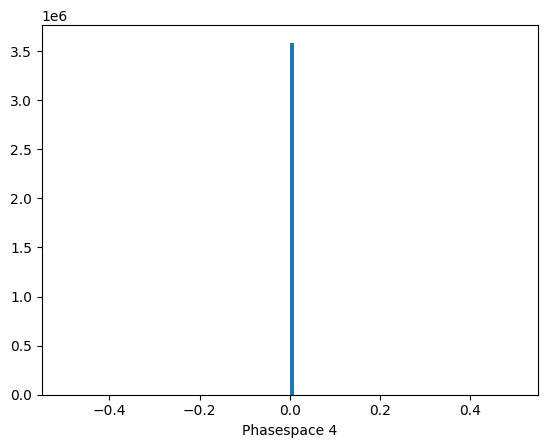

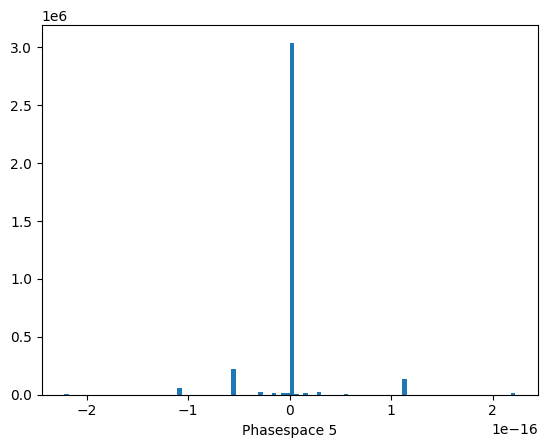

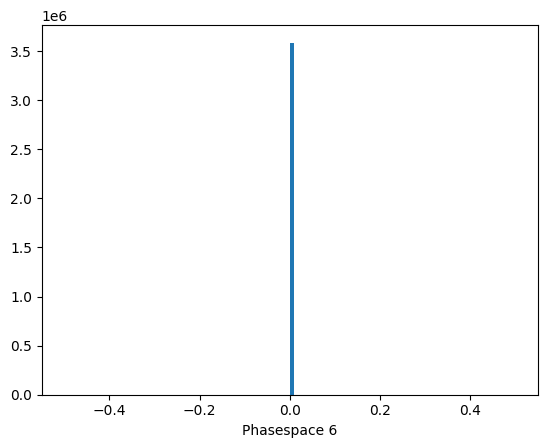

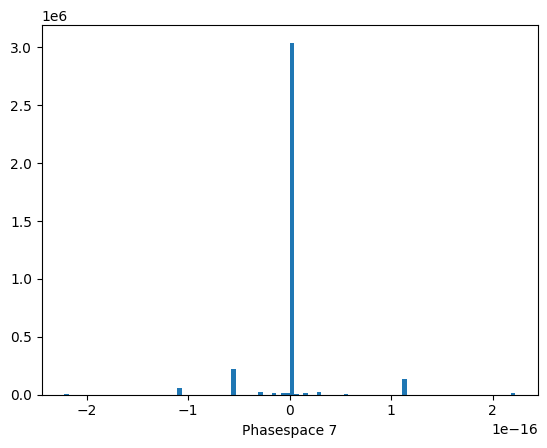

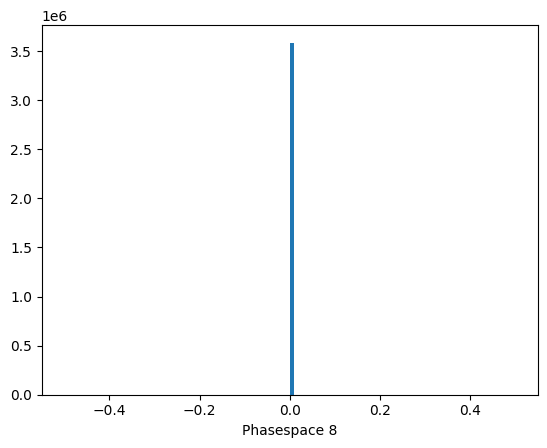

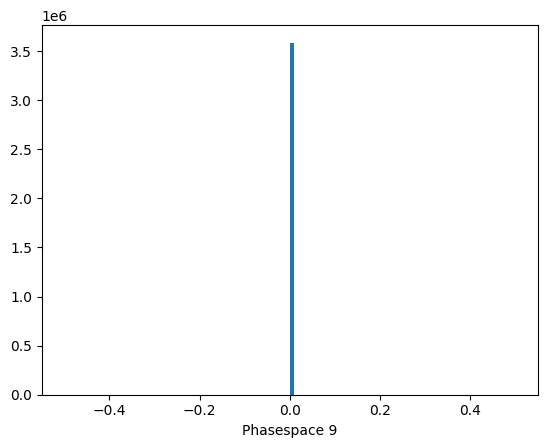

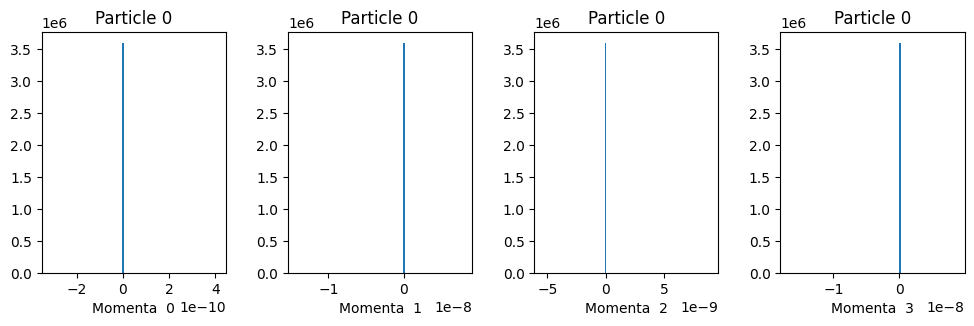

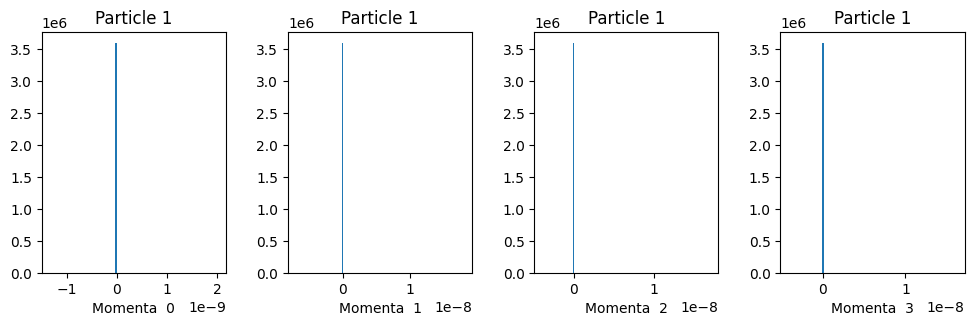

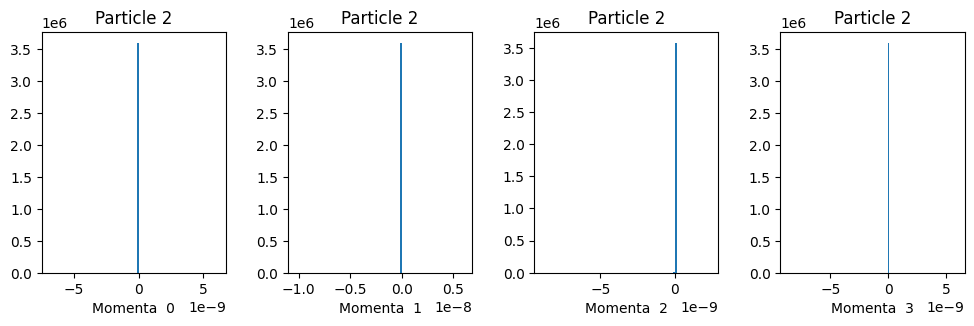

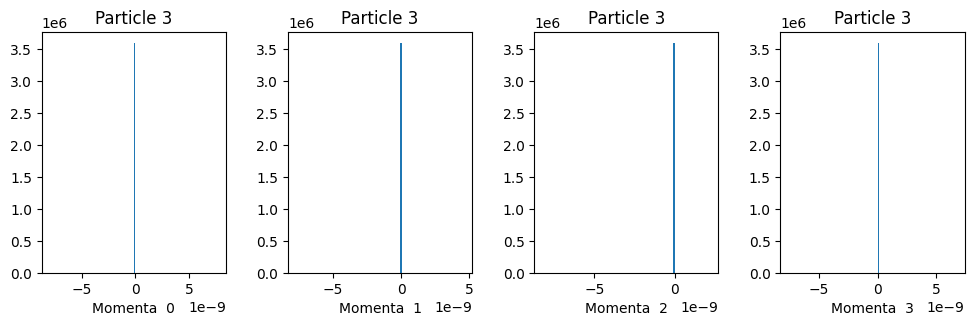

In [32]:
particles = 4
for j in range(particles):
    f, axs = plt.subplots(1, 4, figsize=(10,3))
    plt.tight_layout()
    for i in range(4):
        ax = axs[i]
        ax.hist(data_onShell[:,j,i].numpy() - mom[:,j+2,i].numpy(), bins=100)
        ax.set_xlabel(f"Momenta {i}")
        ax.set_title(f"Particle {j}")

plt.figure()
for i in range(10):
    plt.hist((PS_onShell-PS)[:,i].numpy(), bins=100)
    plt.xlabel(f"Phasespace {i}")
    plt.show()

for j in range(particles):
    f, axs = plt.subplots(1, 4, figsize=(10,3))
    plt.tight_layout()
    for i in range(4):
        ax = axs[i]
        ax.hist(mom2[:,j+2,i].numpy() - mom[:,j+2,i].numpy(), bins=100)
        ax.set_xlabel(f"Momenta  {i}")
        ax.set_title(f"Particle {j}")

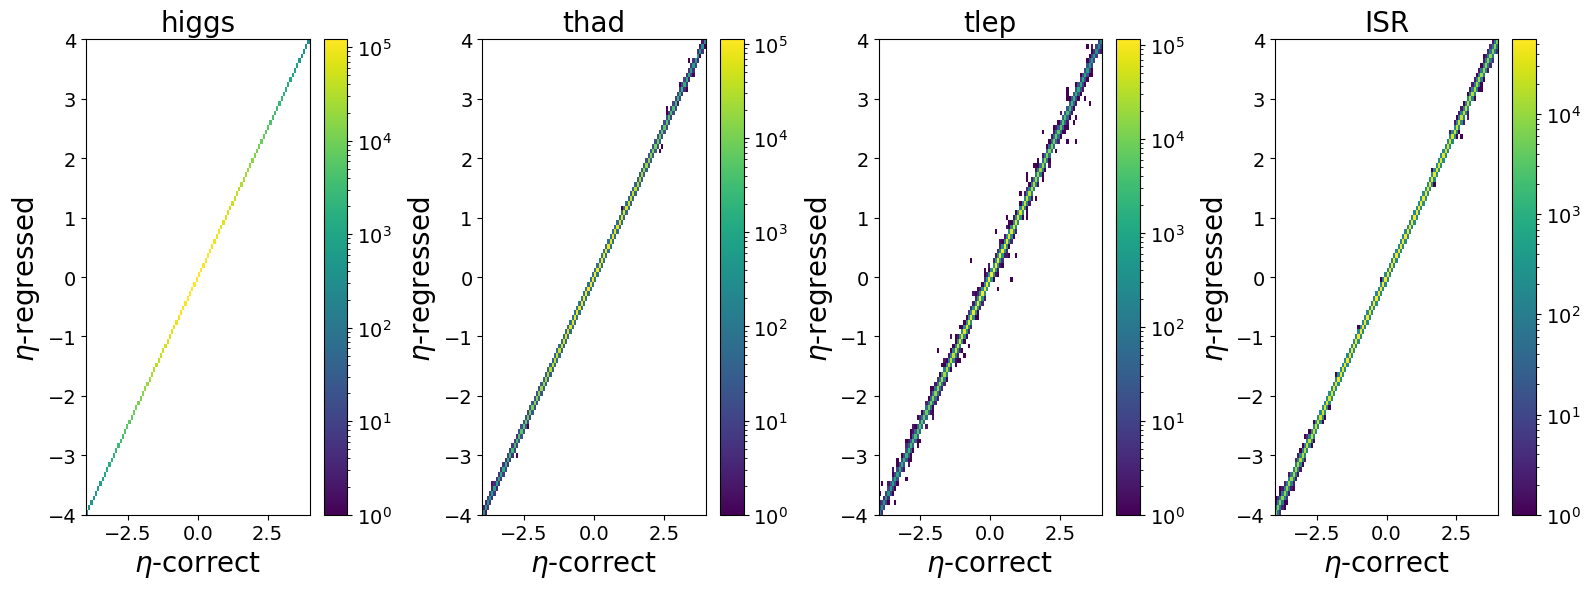

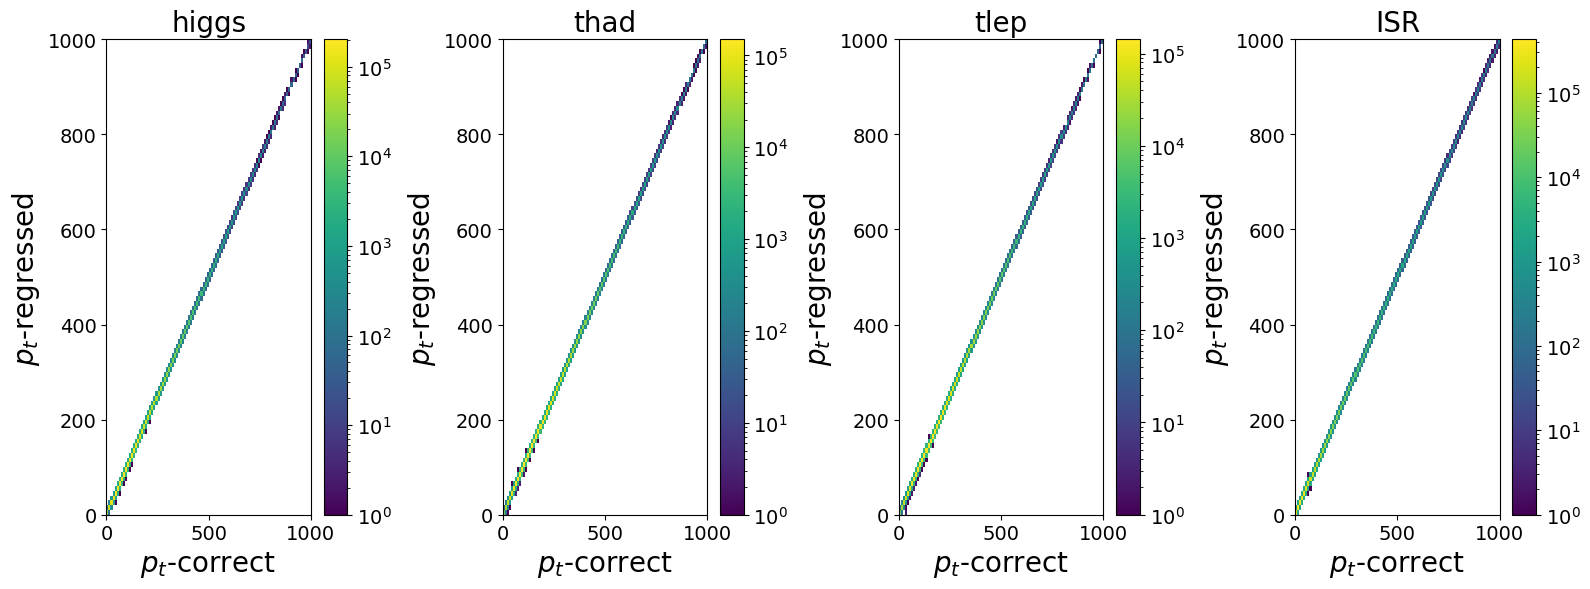

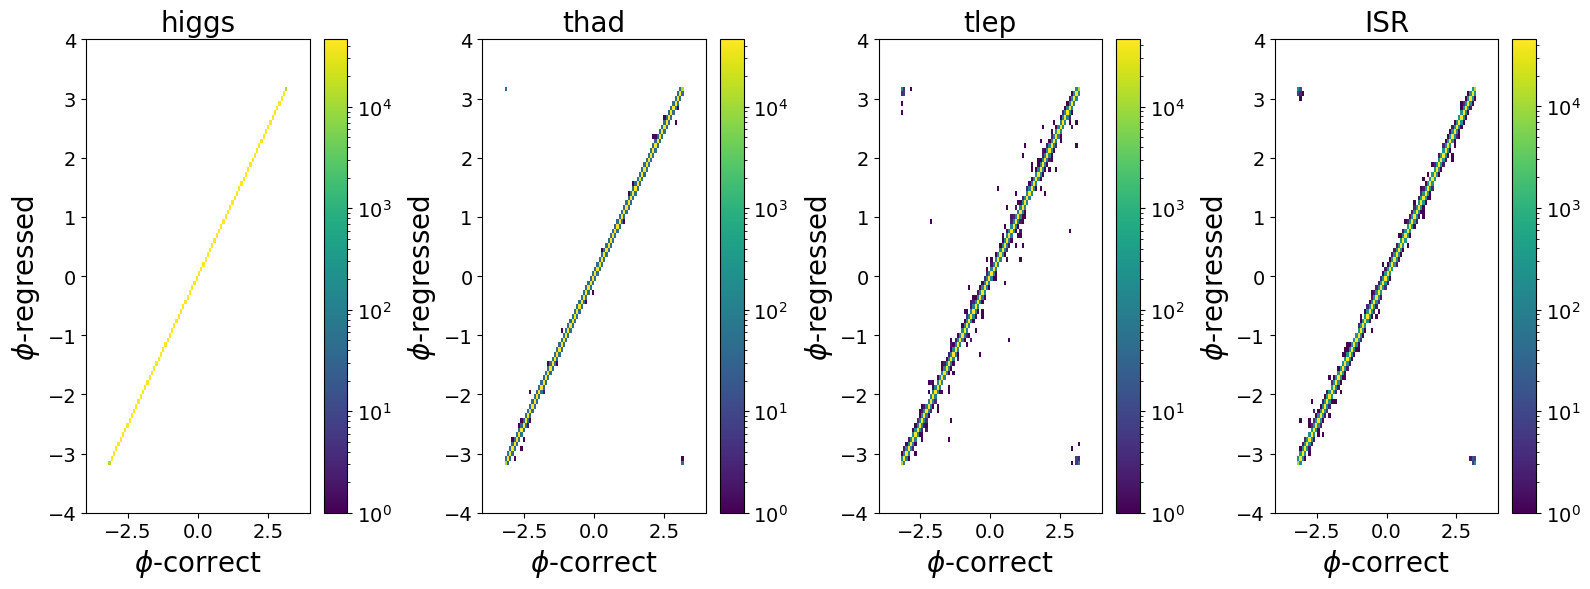

In [9]:
mom, w, x11, x22 = phasespace.get_momenta_from_ps(PS)

higgs = mom[:,2]
t = mom[:,3]
tbar = mom[:,4]
isr = mom[:,5]

higgs = vector.array(
    {
        "E": higgs[:,0].detach().numpy(),
        "px": higgs[:,1].detach().numpy(),
        "py": higgs[:,2].detach().numpy(),
        "pz": higgs[:,3].detach().numpy()
    }
)

t = vector.array(
    {
        "E": t[:,0].detach().numpy(),
        "px": t[:,1].detach().numpy(),
        "py": t[:,2].detach().numpy(),
        "pz": t[:,3].detach().numpy()
    }
)

tbar = vector.array(
    {
        "E": tbar[:,0].detach().numpy(),
        "px": tbar[:,1].detach().numpy(),
        "py": tbar[:,2].detach().numpy(),
        "pz": tbar[:,3].detach().numpy()
    }
)

isr = vector.array(
    {
        "E": isr[:,0].detach().numpy(),
        "px": isr[:,1].detach().numpy(),
        "py": isr[:,2].detach().numpy(),
        "pz": isr[:,3].detach().numpy()
    }
)

higgs = ak.with_name(higgs, name="Momentum4D")
t = ak.with_name(t, name="Momentum4D")
tbar = ak.with_name(tbar, name="Momentum4D")
isr = ak.with_name(isr, name="Momentum4D")

mask = range(len(higgsCorrect.eta))

plot_var2d(higgs_var1=higgsCorrect.eta, higgs_var2=higgs.eta,
           thad_var1=thadCorrect.eta, thad_var2=t.eta,
           tlep_var1=tlepCorrect.eta, tlep_var2=tbar.eta,
           ISR_var1=glISRCorrect.eta, ISR_var2=isr.eta,
           name1='$eta-correct$', name2='$eta-regressed$', nameFig='29.png', 
           start1=-4, stop1=4, start2=-4, stop2=4, bins1=100, bins2=100,
           higgs_mask=mask, thad_mask=mask, tlep_mask=mask, ISR_mask=mask,
           neg_Mask=False, log=True, name='$\eta$')

plot_var2d(higgs_var1=higgsCorrect.pt, higgs_var2=higgs.pt,
           thad_var1=thadCorrect.pt, thad_var2=t.pt,
           tlep_var1=tlepCorrect.pt, tlep_var2=tbar.pt,
           ISR_var1=glISRCorrect.pt, ISR_var2=isr.pt,
           name1='$pt-correct$', name2='$pt-regressed$', nameFig='29.png', 
           start1=0, stop1=1000, start2=0, stop2=1000, bins1=100, bins2=100,
           higgs_mask=mask, thad_mask=mask, tlep_mask=mask, ISR_mask=mask,
           neg_Mask=False, log=True, name='$p_t$')

plot_var2d(higgs_var1=higgsCorrect.phi, higgs_var2=higgs.phi,
           thad_var1=thadCorrect.phi, thad_var2=t.phi,
           tlep_var1=tlepCorrect.phi, tlep_var2=tbar.phi,
           ISR_var1=glISRCorrect.phi, ISR_var2=isr.phi,
           name1='$phi-correct$', name2='$phi-regressed$', nameFig='29.png', 
           start1=-4, stop1=4, start2=-4, stop2=4, bins1=100, bins2=100,
           higgs_mask=mask, thad_mask=mask, tlep_mask=mask, ISR_mask=mask,
           neg_Mask=False, log=True, name='$\phi$')

# PS CLAMP

In [23]:
eps = 5e-5

PS_clamp = PS_onShell.clone().detach()
mask0 = PS_clamp < eps
mask1 = PS_clamp > 1-eps
PS_clamp[mask0] = eps
PS_clamp[mask1] = 1-eps
print(torch.count_nonzero(mask0) + torch.count_nonzero(mask1))
print((PS_clamp == PS_onShell).all())

tensor(11127)
tensor(False)


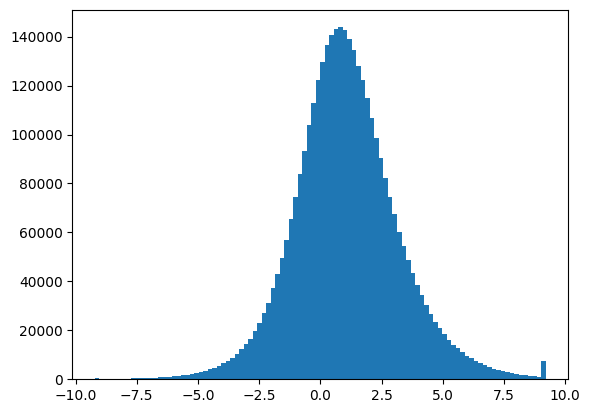

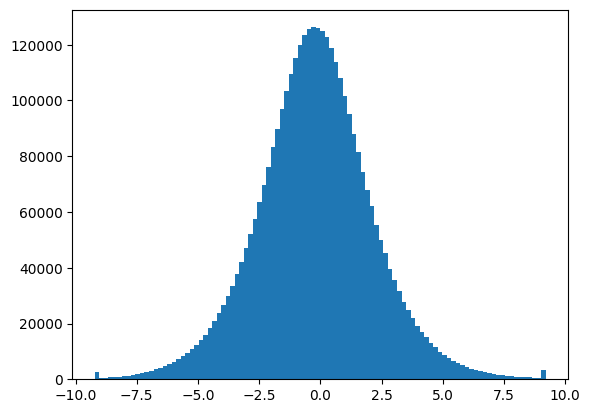

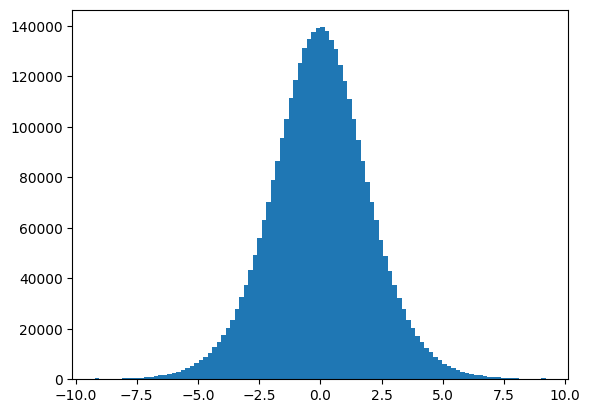

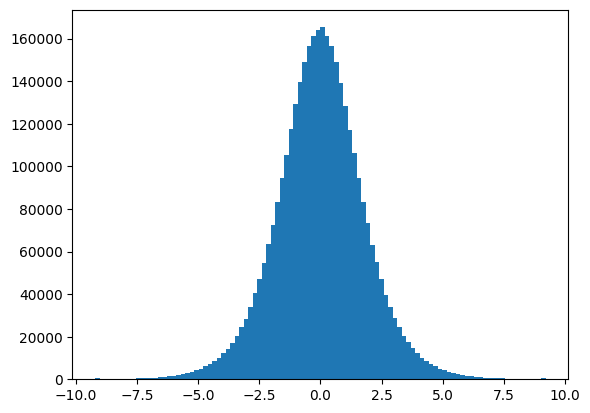

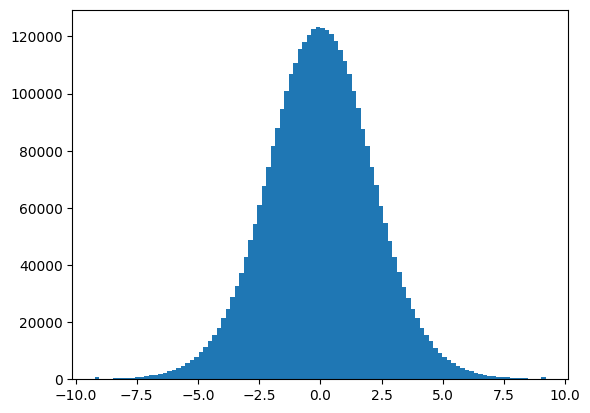

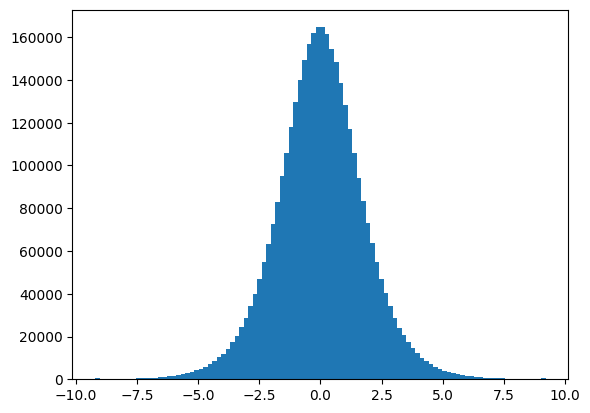

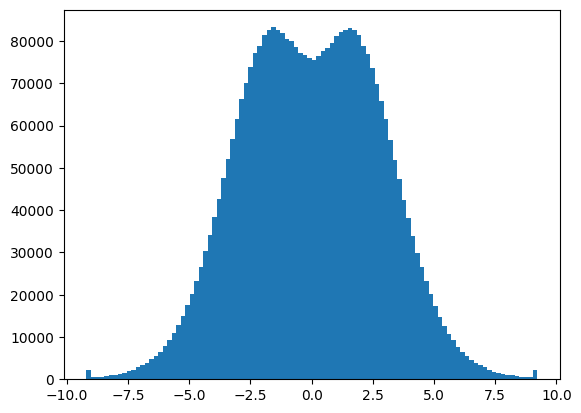

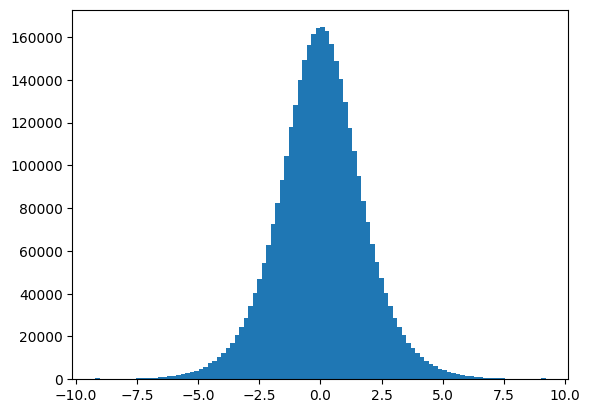

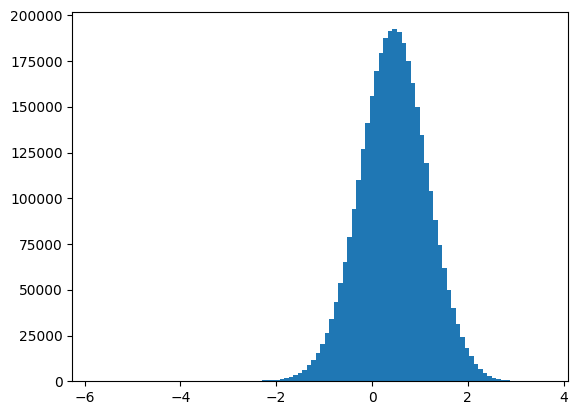

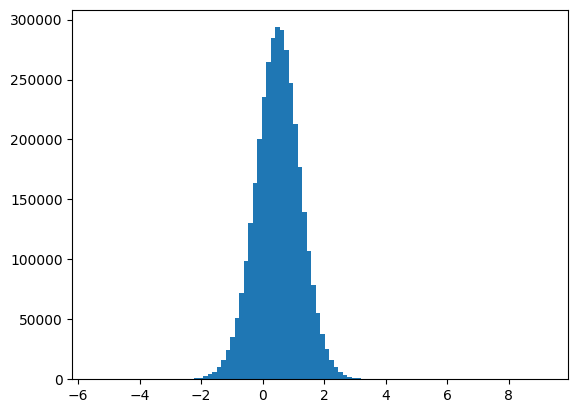

In [24]:
for i in range(10):

    plt.hist(torch.logit(PS_clamp[:,i], 1e-4).detach().numpy(), bins=100)
    plt.show()

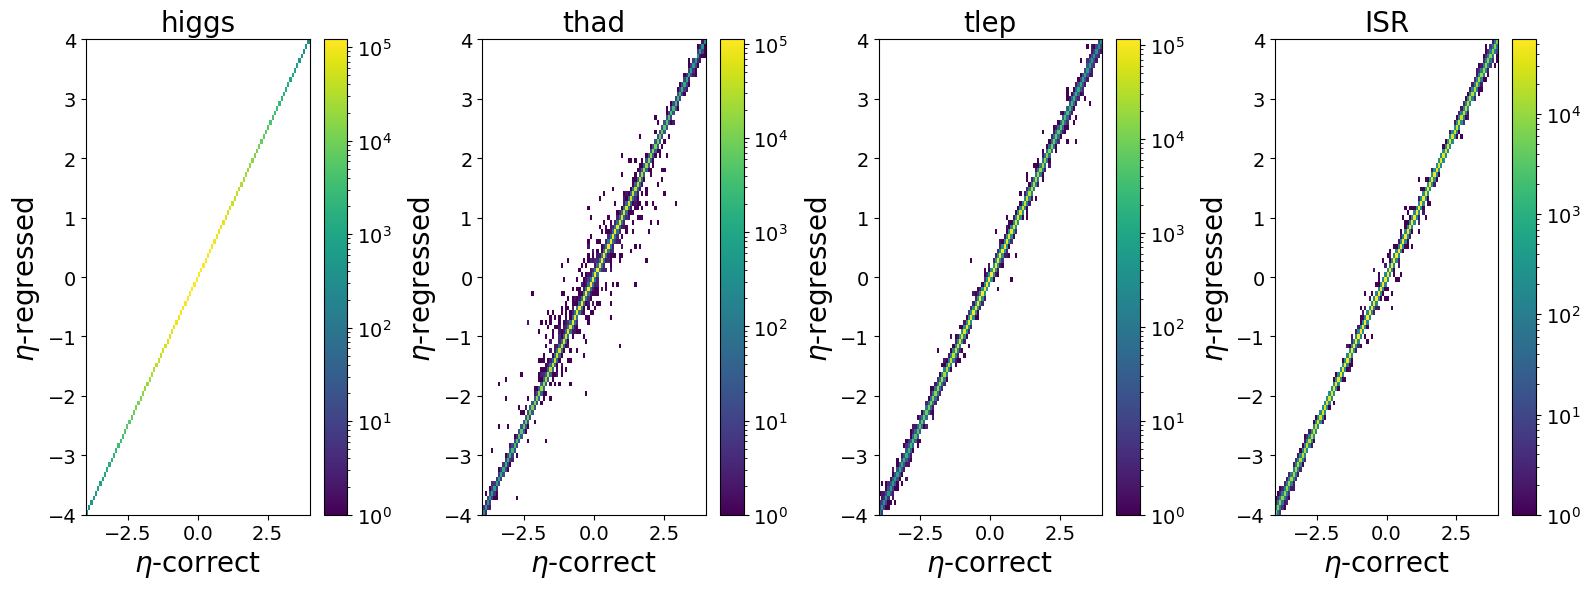

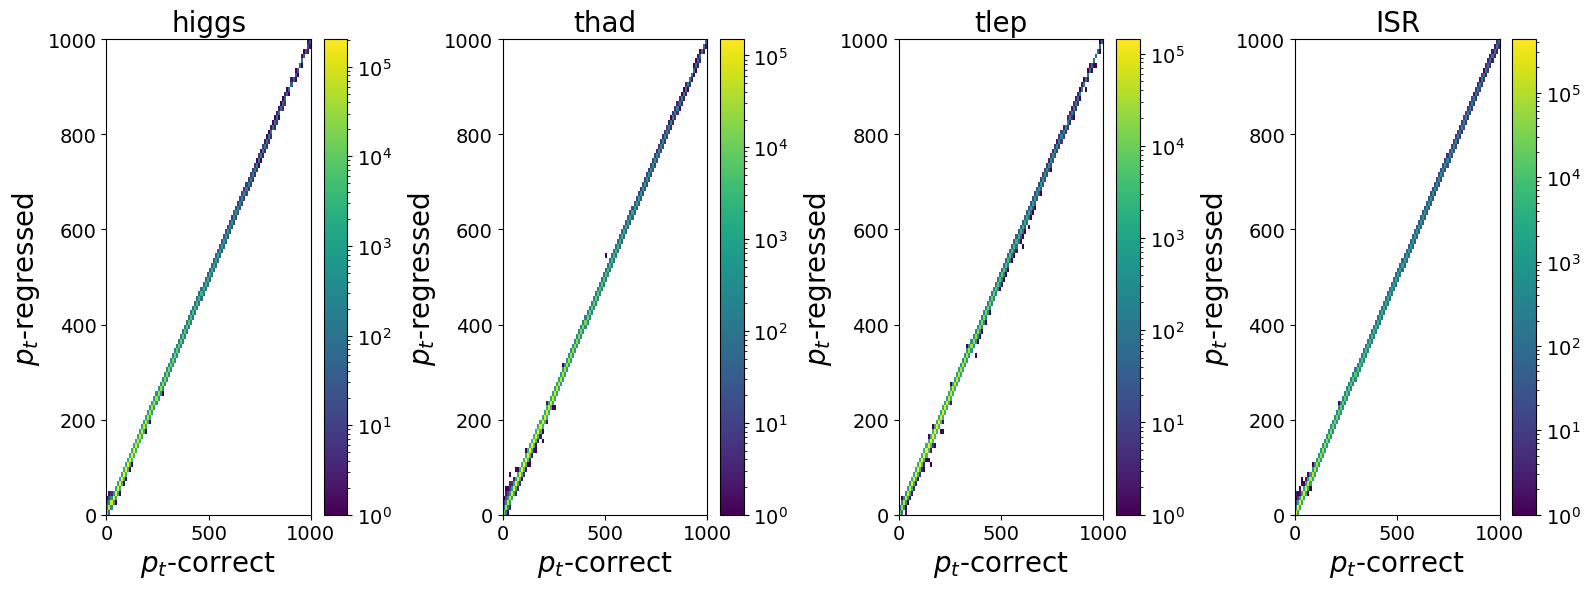

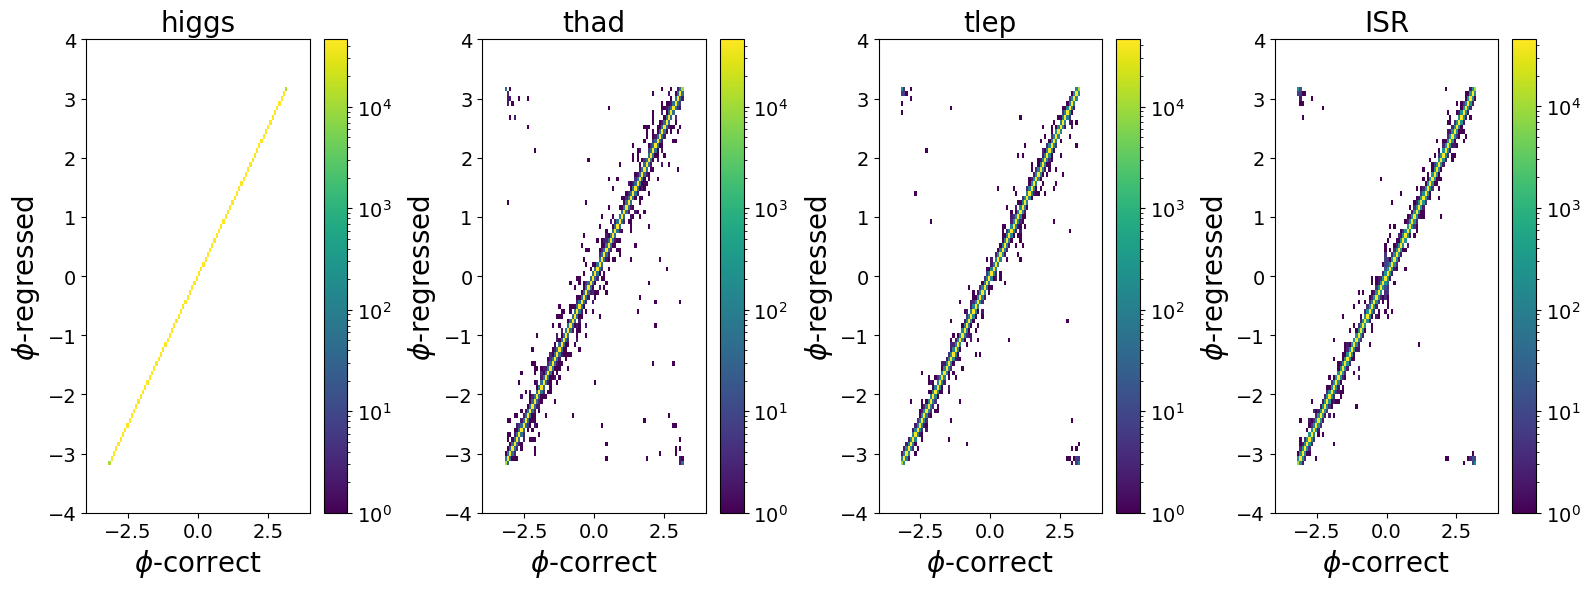

In [25]:
mom, w, x11, x22 = phasespace.get_momenta_from_ps(PS_clamp)

higgs = mom[:,2]
t = mom[:,3]
tbar = mom[:,4]
isr = mom[:,5]

higgs = vector.array(
    {
        "E": higgs[:,0].detach().numpy(),
        "px": higgs[:,1].detach().numpy(),
        "py": higgs[:,2].detach().numpy(),
        "pz": higgs[:,3].detach().numpy()
    }
)

t = vector.array(
    {
        "E": t[:,0].detach().numpy(),
        "px": t[:,1].detach().numpy(),
        "py": t[:,2].detach().numpy(),
        "pz": t[:,3].detach().numpy()
    }
)

tbar = vector.array(
    {
        "E": tbar[:,0].detach().numpy(),
        "px": tbar[:,1].detach().numpy(),
        "py": tbar[:,2].detach().numpy(),
        "pz": tbar[:,3].detach().numpy()
    }
)

isr = vector.array(
    {
        "E": isr[:,0].detach().numpy(),
        "px": isr[:,1].detach().numpy(),
        "py": isr[:,2].detach().numpy(),
        "pz": isr[:,3].detach().numpy()
    }
)

higgs = ak.with_name(higgs, name="Momentum4D")
t = ak.with_name(t, name="Momentum4D")
tbar = ak.with_name(tbar, name="Momentum4D")
isr = ak.with_name(isr, name="Momentum4D")

mask = range(len(higgsCorrect.eta))

plot_var2d(higgs_var1=higgsCorrect.eta, higgs_var2=higgs.eta,
           thad_var1=thadCorrect.eta, thad_var2=t.eta,
           tlep_var1=tlepCorrect.eta, tlep_var2=tbar.eta,
           ISR_var1=glISRCorrect.eta, ISR_var2=isr.eta,
           name1='$eta-correct$', name2='$eta-regressed$', nameFig='29.png', 
           start1=-4, stop1=4, start2=-4, stop2=4, bins1=100, bins2=100,
           higgs_mask=mask, thad_mask=mask, tlep_mask=mask, ISR_mask=mask,
           neg_Mask=False, log=True, name='$\eta$')

plot_var2d(higgs_var1=higgsCorrect.pt, higgs_var2=higgs.pt,
           thad_var1=thadCorrect.pt, thad_var2=t.pt,
           tlep_var1=tlepCorrect.pt, tlep_var2=tbar.pt,
           ISR_var1=glISRCorrect.pt, ISR_var2=isr.pt,
           name1='$pt-correct$', name2='$pt-regressed$', nameFig='29.png', 
           start1=0, stop1=1000, start2=0, stop2=1000, bins1=100, bins2=100,
           higgs_mask=mask, thad_mask=mask, tlep_mask=mask, ISR_mask=mask,
           neg_Mask=False, log=True, name='$p_t$')

plot_var2d(higgs_var1=higgsCorrect.phi, higgs_var2=higgs.phi,
           thad_var1=thadCorrect.phi, thad_var2=t.phi,
           tlep_var1=tlepCorrect.phi, tlep_var2=tbar.phi,
           ISR_var1=glISRCorrect.phi, ISR_var2=isr.phi,
           name1='$phi-correct$', name2='$phi-regressed$', nameFig='29.png', 
           start1=-4, stop1=4, start2=-4, stop2=4, bins1=100, bins2=100,
           higgs_mask=mask, thad_mask=mask, tlep_mask=mask, ISR_mask=mask,
           neg_Mask=False, log=True, name='$\phi$')

# check

In [15]:
ps = torch.rand(10).unsqueeze(dim=0)
print(ps)
mom, w, x1, x2 = phasespace.get_momenta_from_ps(ps, target_mass=torch.Tensor([125.25, 172.5, 172.5, 0.01]))

ps2, detjac = phasespace.get_ps_from_momenta(mom[:,2:], x1,x2)
mom2, w, x1, x2 = phasespace.get_momenta_from_ps(ps2, target_mass=torch.Tensor([125.25, 172.5, 172.5, 0.01]))

tensor([[0.2712, 0.0360, 0.6406, 0.8844, 0.3981, 0.0774, 0.0770, 0.0359, 0.2477,
         0.6877]])


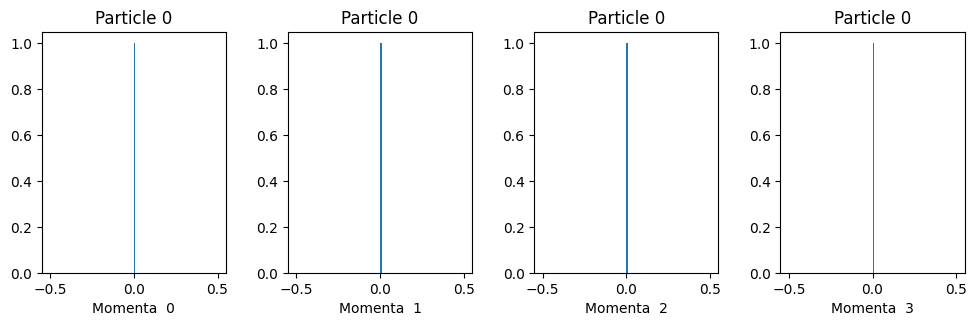

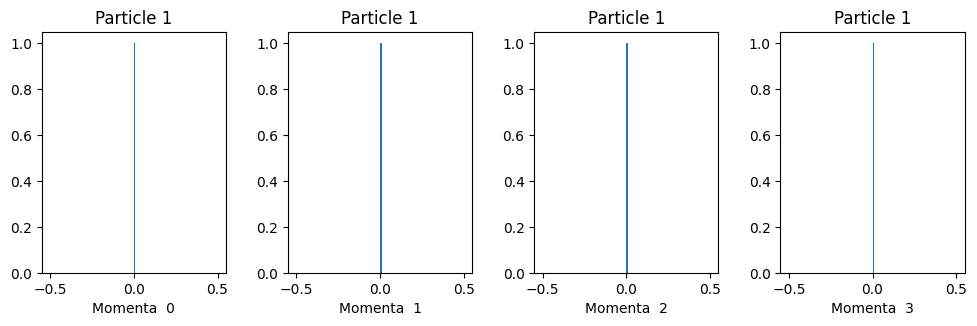

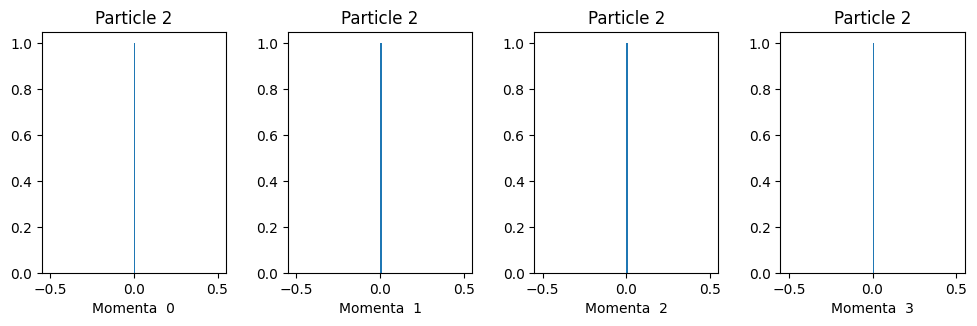

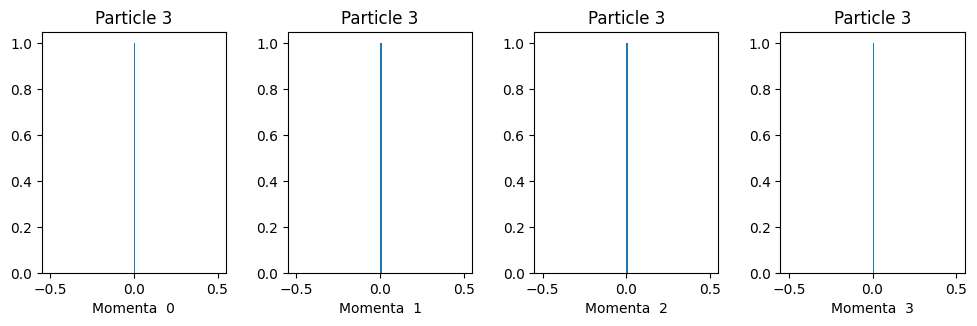

In [16]:
particles = 4

for j in range(particles):
    f, axs = plt.subplots(1, 4, figsize=(10,3))
    plt.tight_layout()
    for i in range(4):
        ax = axs[i]
        ax.hist(mom2[:,j+2,i].numpy() - mom[:,j+2,i].numpy(), bins=100)
        ax.set_xlabel(f"Momenta  {i}")
        ax.set_title(f"Particle {j}")

# Check orders

In [26]:
import itertools
y = list(itertools.permutations([1, 2, 3]))
for x in y:
    print(list(x))

[1, 2, 3]
[1, 3, 2]
[2, 1, 3]
[2, 3, 1]
[3, 1, 2]
[3, 2, 1]


In [31]:
phasespace = PhaseSpace(E_CM, [21, 21], [25, 6, -6, 21], final_masses=torch.Tensor([125.25, 172.5, 172.5, 0.000]), dev="cpu")
orders = list(itertools.permutations([0, 1, 2, 3]))

for x in orders:
    x = list(x)
    print(x)
    PS, detjac = phasespace.get_ps_from_momenta(data_onShell, x1, x2, order=x)
    
    eps = 1e-4
    mask0 = PS < eps
    mask1 = PS > 1-eps
    
    eps = 1e-5
    mask2 = PS < eps
    mask3 = PS > 1-eps
    print(f'for order: {x} -> result: {torch.count_nonzero(mask0) + torch.count_nonzero(mask1)} & {torch.count_nonzero(mask2) + torch.count_nonzero(mask3)}')

Phasespace class: masses: tensor([125.2500, 172.5000, 172.5000,   0.0000])
[0, 1, 2, 3]
for order: [0, 1, 2, 3] -> result: 20180 & 2995
[0, 1, 3, 2]
for order: [0, 1, 3, 2] -> result: 20113 & 2976
[0, 2, 1, 3]
for order: [0, 2, 1, 3] -> result: 20417 & 2921
[0, 2, 3, 1]
for order: [0, 2, 3, 1] -> result: 20385 & 2931
[0, 3, 1, 2]
for order: [0, 3, 1, 2] -> result: 28743 & 4240
[0, 3, 2, 1]
for order: [0, 3, 2, 1] -> result: 28758 & 4226
[1, 0, 2, 3]
for order: [1, 0, 2, 3] -> result: 23534 & 3583
[1, 0, 3, 2]
for order: [1, 0, 3, 2] -> result: 23467 & 3564
[1, 2, 0, 3]
for order: [1, 2, 0, 3] -> result: 21131 & 3103
[1, 2, 3, 0]
for order: [1, 2, 3, 0] -> result: 21150 & 3096
[1, 3, 0, 2]
for order: [1, 3, 0, 2] -> result: 34677 & 5511
[1, 3, 2, 0]
for order: [1, 3, 2, 0] -> result: 34603 & 5510
[2, 0, 1, 3]
for order: [2, 0, 1, 3] -> result: 25312 & 3948
[2, 0, 3, 1]
for order: [2, 0, 3, 1] -> result: 25280 & 3958
[2, 1, 0, 3]
for order: [2, 1, 0, 3] -> result: 22829 & 3462
[2, 1, 3, 